# Flowlines and motion paths using PyGPlates

PyGPlates can be used to calculate [flowlines](https://www.gplates.org/docs/pygplates/sample-code/pygplates_reconstruct_flowline_features.html) and [motion paths](https://www.gplates.org/docs/pygplates/sample-code/pygplates_reconstruct_motion_path_features.html), similar to how you might in the desktop GPlates app (links to the GPlates documentation for [flowlines](https://www.gplates.org/docs/user-manual/Flowlines/) and [motion path](https://www.gplates.org/docs/user-manual/MotionPaths/)).

Flowlines are often used to track plate motion away from a spreading ridge using half-stage rotations, while motion paths track plate motion relative to a specified plate - often the absolute reference frame. 

When creating a flowline or motion path, you can select your left and right plate IDs (for flowlines), or moving and fixed plate (for motion paths), and a series of times to reconstruct them over.

---
First, import modules.

In [116]:
import numpy as np
import pygplates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import LineString
import geopandas as gpd

---
# Flowlines

## Create flowline feature


First, let's define our flowline 'seed points' and other parameters. Here, we'll choose points along the mid-ocean ridge in the South Atlantic

In [460]:
# --- Parameters for the flowlines (similar to the GPlates app)
# seed_points are in (lat, lon) format
seed_points = [(-1.60584, -15.4795), (-11.9764, -14.9688), (-25.7209, -14.0632), (-35.7228, -17.7739)]
left_plate_ID = 201
right_plate_ID = 701
times = np.arange(0, 121, 1)

Next, we create the flowline feature using [`pygplates.Feature.create_flowline`](https://www.gplates.org/docs/pygplates/generated/pygplates.feature?highlight=create_flowline#pygplates.Feature.create_flowline)

In [461]:
multi_point = pygplates.MultiPointOnSphere(seed_points)
print(multi_point.to_lat_lon_array())   # sanity check our seed point coordinates!

# Create the flowline feature
flowline_feature = pygplates.Feature.create_flowline(multi_point, times, valid_time=(np.max(times), np.min(times)), 
                                                     left_plate=left_plate_ID, right_plate=right_plate_ID)

[[ -1.60584 -15.4795 ]
 [-11.9764  -14.9688 ]
 [-25.7209  -14.0632 ]
 [-35.7228  -17.7739 ]]


## Create reconstructed flowlines based on a particular rotation model

Flowline features are not tied to a particular rotation model, and you'll notice we haven't even loaded in a rotation file yet!

Next, we'll make a synthetic flowline by loading up our rotation file and using `pygplates.reconstruct`. Here, we need to set our *reconstruct_type* to be [pygplates.ReconstructType.flowline](https://www.gplates.org/docs/pygplates/generated/pygplates.reconstructedflowline#pygplates.ReconstructedFlowline) so that it has our desired flowline properties

In [462]:
# --- Name of input rotation file
rotation_filename = 'Data/Muller2019-Young2019-Cao2020_CombinedRotations.rot'
rotation_model = pygplates.RotationModel(rotation_filename)

# reconstruct the flowline - we want it in present day coordinates
reconstruction_time = 0

# create an empty feature in which the reconstructed flowline geometries will be placed
reconstructed_flowlines = []

# call pygplates to generate the flowline feature
pygplates.reconstruct(flowline_feature, rotation_model, reconstructed_flowlines, reconstruction_time, 
                      anchor_plate_id=0, reconstruct_type=pygplates.ReconstructType.flowline)

## Visualise results

A useful way of assessing synthetic flowlines is to plot and compare them against seafloor fabric, such as fracture zones, or to gravity anomalies. Ideally, the flowlines should match the fracture zone geometry.

First we need to import some fracture zones and gravity, and then we can plot it all up. 


### A `geopandas` example using fracture zones

For the fracture zones, we will convert the *pygplates.FeatureCollection* using [`geopandas`](https://geopandas.org/en/stable/) and [`shapely`](https://shapely.readthedocs.io/en/stable/).

In [463]:
# Import fracture zones
fracture_zone_file = 'Data/FZ_cookiecut.gpmlz'
fracture_zones = pygplates.FeatureCollection(fracture_zone_file)

# It can be helpful to convert FeatureCollections into a GeoDataFrame for when we want to plot things.
# GeoDataFrames contain the geometries as Shapely geometries, contained within the 'geometry' column 
# (and it must be called 'geometry'). 
# Using a GeoDataFrame means we can also preserve other feature attributes (e.g. plate ID, etc)

# Wrap things to the dateline, to avoid plotting artefacts.
date_line_wrapper = pygplates.DateLineWrapper()

# empty arrays to write things to
output_geoms = []
plateids = []
from_ages = []

# Iterate through
for fz in fracture_zones:
    if fz.get_geometry() is not None:
        line = fz.get_geometry()
        wrapped_line = date_line_wrapper.wrap(line)
        for poly in wrapped_line:
            output_geom = LineString(p.to_lat_lon()[::-1] for p in poly.get_points())
            output_geoms.append(output_geom)
            
            # Get some other attributes
            plateids.append(fz.get_reconstruction_plate_id())
            from_age, to_age = fz.get_valid_time()
            from_ages.append(from_age)
            
# Create GeoDataFrame
gpd_fz = gpd.GeoDataFrame()
gpd_fz['PLATEID1'] = plateids
gpd_fz['FROMAGE'] = from_ages
gpd_fz['geometry'] = output_geoms
gpd_fz = gpd_fz.set_crs(epsg=4326)  # set crs

# quickly check the geodataframe
gpd_fz.head()

,PLATEID1,FROMAGE,geometry
0,801,0.0,"LINESTRING (120.56453 -49.23437, 120.75621 -48..."
1,802,55.9,"LINESTRING (24.84343 -57.92575, 24.84319 -57.8..."
2,802,55.9,"LINESTRING (25.20295 -57.94535, 25.27250 -57.6..."
3,802,55.9,"LINESTRING (25.56843 -57.96421, 25.92128 -57.5..."
4,802,55.9,"LINESTRING (26.67811 -56.92760, 26.70754 -56.6..."


Import gravity jpg.

In [464]:
# ---- Read in and plot gravity
grav_file = 'Data/Vertical_Gravity_Gradient.jpg'
img_extent = (-180, 180, -90, 90)
img = plt.imread(grav_file)

### Plot

As part of this, we will iterate through the 'left' and 'right' sides of the flowline features

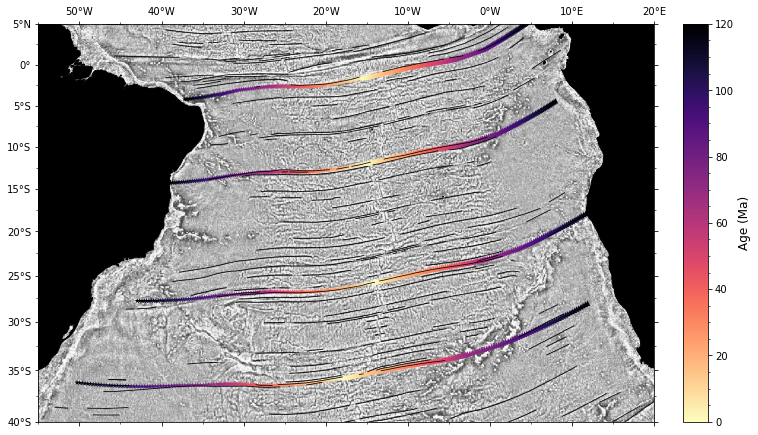

In [470]:
# --- Create figure

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection=ccrs.Mercator())

# --- Plot tick labels
ax.set_xticks(np.arange(-180, 190, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 95, 5), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-180, 185, 5), minor=True, crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 2.5), minor=True, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.tick_top()  # labelled ticks on top
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_ticks_position('both')   # ticks on both top/bottom
ax.yaxis.set_ticks_position('both')   # ticks on both left/right


# --- Limit map extent
west = -55
east = 20
south = -40.
north = 5
ax.set_extent([west, east, south, north], crs=ccrs.PlateCarree())

# ---- Plot gravity
ax.imshow(img, cmap='Greys_r', origin='upper', extent=img_extent, alpha=0.75,
          transform=ccrs.PlateCarree(), zorder=1)

# --- Plot filled coastlines
ax.add_feature(cfeature.LAND, color='k', zorder=2)   # use zorder to that they plot ontop of gravity

# --- Plot fracture zones
gpd_fz.plot(ax=ax, color='k', linewidth=0.75, transform=ccrs.PlateCarree())

# --- Iterate over the reconstructed flowlines. Each seed point results in a 'left' and 'right' flowline 
for reconstructed_flowline in reconstructed_flowlines:
    
    flowline_times = reconstructed_flowline.get_feature().get_times()
    
    # --- left flowline
    flowline_left = []
    
    # Get the points for the left flowline only
    for left_point in reconstructed_flowline.get_left_flowline():
        flowline_left = np.append(flowline_left, left_point.to_lat_lon_array())  # append lat-lon points to our empty array 
    
    # Repeat for the right flowline points
    flowline_right = []
    for right_point in reconstructed_flowline.get_right_flowline():
        flowline_right = np.append(flowline_right, right_point.to_lat_lon_array())
    
    # get the lat and lon coordinates
    flowline_left_lon, flowline_left_lat = flowline_left[1::2], flowline_left[::2]
    flowline_right_lon, flowline_right_lat = flowline_right[1::2], flowline_right[::2]
    
    # plot flowlines
    fl = ax.scatter(flowline_left_lon, flowline_left_lat, 30, marker='*', c=flowline_times,
                    transform=ccrs.PlateCarree(), cmap=plt.cm.magma_r, edgecolor='none',
                    vmin=flowline_times[0], vmax=flowline_times[-1])

    ax.scatter(flowline_right_lon, flowline_right_lat, 30, marker='^', c=times,
               transform=ccrs.PlateCarree(), cmap=plt.cm.magma_r, edgecolor='none',
               vmin=flowline_times[0], vmax=flowline_times[-1])
    
# --- Set a colorbar to help visualise the passage of every Xth Myr.
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="4%", pad=0.4, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(fl, cax=cax, orientation="vertical")
cbar.set_label('Age (Ma)', fontsize=12)
cbar.ax.minorticks_on()

plt.show()

---
# Motion paths

## Create motion path feature

This is fairly similar to creating a flowline, except we specify that it is a motion path.

This time, we'll use the location of the Hawaii hotspot.

In [522]:
# --- Parameters for the motion path (similar to the GPlates app)
# seed_point is in (lat, lon) format
seed_point = (19, -155)
plate_ID = 2
relative_plate_ID = 901

time_increment = 2
times = np.arange(0, 102, time_increment)

Create the motion path feature, this time using [`pygplates.Feature.create_motion_path`](https://www.gplates.org/docs/pygplates/generated/pygplates.feature#pygplates.Feature.create_motion_path). Similar to the flowline example, we don't specify the rotation file yet.

In [523]:
seed_points_at_digitisation_time = pygplates.PointOnSphere(seed_point)

motion_path_feature = pygplates.Feature.create_motion_path(seed_points_at_digitisation_time, 
                                                           times, valid_time=(200., 0.),
                                                           relative_plate=relative_plate_ID,
                                                           reconstruction_plate_id = plate_ID)

## Generate the actual motion path geometry

Generate the actual motion path geometry predicted by the rotation model using `pygplates.reconstruct`. This time we specify our 
*reconstruct_type* to be [pygplates.ReconstructType.motion_path](https://www.gplates.org/docs/pygplates/generated/pygplates.reconstructedmotionpath#pygplates.ReconstructedMotionPath) so that it has our desired motion path properties.

In this example, we will use the [Wessel and Kroenke (2008)](https://doi.org/10.1029/2007JB005499) *WK-08A* rotations, which are included in the [Matthews et al (2016)](http://dx.doi.org/10.1016/j.gloplacha.2016.10.002) rotation file (included with the GPlates 2.2 Sample Data).

In [524]:
rotation_filename = 'Data/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'
rotation_model = pygplates.RotationModel(rotation_filename)

# Create the shape of the motion path
reconstruction_time = 0
reconstructed_motion_paths = []
pygplates.reconstruct(motion_path_feature, rotation_model, reconstructed_motion_paths, reconstruction_time, 
                      reconstruct_type=pygplates.ReconstructType.motion_path)


## Plot the motion path

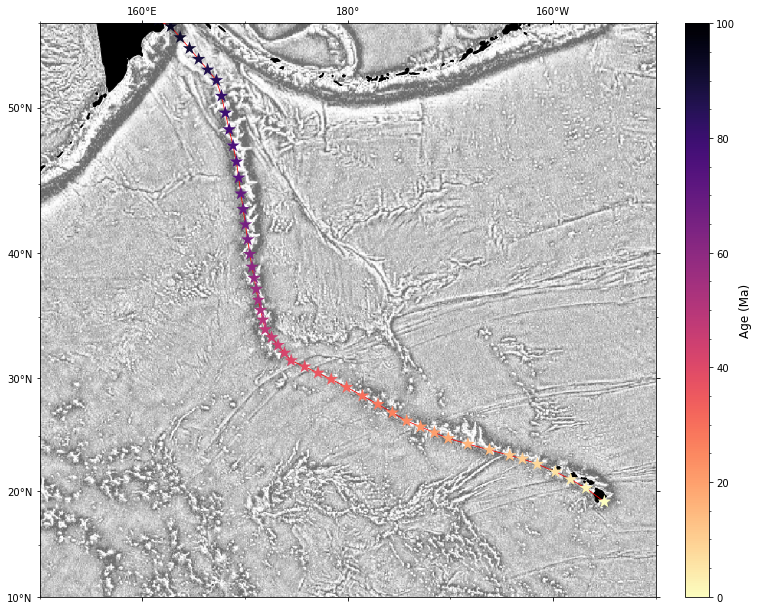

In [525]:
# --- Create figure

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection=ccrs.Mercator(central_longitude=180))

# --- Plot tick labels
ax.set_xticks(np.arange(0, 360, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 100, 10), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(0, 360, 10), minor=True, crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 5), minor=True, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.tick_top()  # labelled ticks on top
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_ticks_position('both')   # ticks on both top/bottom
ax.yaxis.set_ticks_position('both')   # ticks on both left/right

# --- Limit map extent
lon_min = 150.
lon_max = 210  # if I specify as -150, it will plot as the 'other' way around the world
lat_min = 10.
lat_max = 55
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())


# ---- Plot gravity
ax.imshow(img, cmap='Greys_r', origin='upper', extent=img_extent, alpha=0.6,
          transform=ccrs.PlateCarree(central_longitude=0), zorder=1)

# --- Plot filled coastlines
ax.add_feature(cfeature.LAND, color='k', zorder=2)

# --- Get the reconstructed motion path.
# This is easier than flowlines, since we don't have left and right sides
date_line_wrapper = pygplates.DateLineWrapper()
for reconstructed_motion_path in reconstructed_motion_paths:
    wrapped_line = date_line_wrapper.wrap(line)
    trail = reconstructed_motion_path.get_motion_path().to_lat_lon_array()
    
lon, lat = np.flipud(trail[:, 1]), np.flipud(trail[:, 0])

# convert lons to 360 format (cartopy does not like plotting lines across the antimeridian)
lon_360 = []
for i in lon:
    lon_360.append(i + 360 if i < 0 else i)

# --- plot motion path
ax.plot(lon_360, lat, color='r', linewidth=0.75, transform=ccrs.PlateCarree(), zorder=3)
mp = ax.scatter(lon, lat, 200, marker='*', c=times, cmap=plt.cm.magma_r, edgecolor='none',
                transform=ccrs.PlateCarree(), vmin=times[0], vmax=times[-1], zorder=4)
    
# --- Set a colorbar to help visualise the passage of every Xth Myr.
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="4%", pad=0.4, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(mp, cax=cax, orientation="vertical")
cbar.set_label('Age (Ma)', fontsize=12)
cbar.ax.minorticks_on()


plt.show()

## Quantifying rate of motion through time

Using the sequence of lat/lon coordinates from the motion path seedpoint array, we can then calculate the distance between consecutive points, and consequently, velocity.

Here, we will use pygplates to get the arc length of individual segments within the line feature. By default, distances are produced in units of a normalised sphere, so we multiply by Earth's radius to get the actual distance.


In [526]:
distance = []
for reconstructed_motion_path in reconstructed_motion_paths:
    for segment in reconstructed_motion_path.get_motion_path().get_segments():
        distance.append(segment.get_arc_length() * pygplates.Earth.mean_radius_in_kms)

In [527]:
# Get rate of motion as distance per Myr
rate = np.asarray(distance)/time_increment  # since we created the motion path at X increment

# Note that the motion path coordinates come out starting with the oldest time and working forwards
# So, to match our 'times' array, we flip the order
rate = np.flipud(rate)

### Plot rate

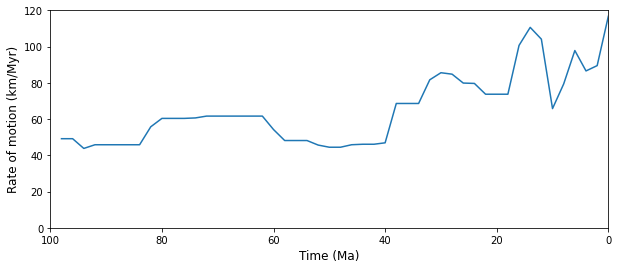

In [532]:
fig = plt.figure(figsize=(10,4))
plt.plot(times[:-1], rate)
plt.xlabel('Time (Ma)', fontsize=12)
plt.xlim(0, 100)
plt.ylim(0, 120)
plt.ylabel('Rate of motion (km/Myr)', fontsize=12)
plt.gca().invert_xaxis()
plt.show()

To plot this as a 'step plot', we need to slightly manipulate the arrays

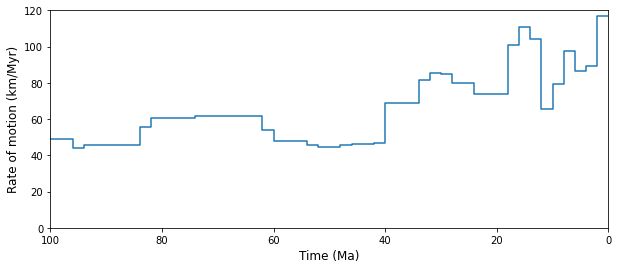

In [540]:
# modify so the rate and time array contain the values for the beginning and end of each step
step_rate = np.zeros(len(rate)*2)
step_rate[::2] = rate
step_rate[1::2] = rate

step_time = np.zeros(len(rate)*2)
step_time[::2] = times[:-1]
step_time[1::2] = times[1:]

# --- plot
fig = plt.figure(figsize=(10,4))
plt.plot(step_time, step_rate)
plt.xlabel('Time (Ma)', fontsize=12)
plt.xlim(0, 100)
plt.ylim(0, 120)
plt.ylabel('Rate of motion (km/Myr)', fontsize=12)
plt.gca().invert_xaxis()
plt.show()
